<a href="https://colab.research.google.com/github/jaekim3220/jupyter/blob/main/15_CNN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한글 폰드 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
from matplotlib import font_manager as fm
import matplotlib.pyplot as plt

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 14, 'font.family': 'NanumGothic'}) # 폰트 설정

In [ ]:
!pip install pca

# CNN을 활용한 MNIST 이미지 분류

## #01. 패키지 준비

In [ ]:
import helper

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## #02. 데이터셋 준비

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')

## #03. 데이터 전처리

결측치 등의 데이터 이상점이 없는 예제 데이터 이므로 생략

## #04. 탐색적 데이터 분석

이미 앞의 예제를 통해 데이터 형태를 확인하였으므로 생략

## 5. 데이터셋 분할하기

### 랜덤시드 고정

In [ ]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

처음부터 데이터 셋이 구분되어 있었으므로 생략

### 훈련 데이터와 검증 데이터로 분할

처음부터 데이터 셋이 구분되어 있었으므로 생략

### 레이블(종속변수)에 대한 one-hot-encoding

***명목형 처리(더미변수/카테고리화)***

- `더미변수`는 `변수의 값이 최소 2개를 초과`할 경우 수행. 아니면 단순 category 타입으로 변경.

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 - 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

>명목형 확인을 위해서는 데이터의 종류가 몇 가지인지 확인.
즉, 명목형으로 의심되면 일단 value_counts()로 확인.
type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능.

>sigmoid는 이항분류, softmax는 다항분류(one-hot-encoding-즉, 더미변수화)

***종속변수 카테고리의 기준***

>탐색적 데이터 분석에서 사용하기 위해 카테고리화를 진행 - (단, 통계에서는 카테고리 형식으로 데이터를 분석하지 않고 int 형식으로 사용)

>정석대로라면 카테고리로 변경하지 않음.
단, 탐색적 데이터 분석을 한다면 명목형 변수를 제거해야 하는데 명목형을 카테고리로 변경하면 자동으로 제거해주기 때문에 카테고리 형식으로 변환 후 진행.

>category 대신 더미변수로 변경하면 int로 돌아오므로 더미변수화를 추천.

In [ ]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 훈련, 검증용 독립변수(이미지)의 차수 재설정

기본 CNN 골격에 맞게 28x28x1로 차원을 변경

CNN은 3차원 이미지(컬러 이미지)

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(f'훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_test_reshape.shape}')

훈련 데이터 (60000, 28, 28, 1) / 검증 데이터 (10000, 28, 28, 1)


### 이미지 데이터 정규화

이미지와 같이 복잡한 데이터의 경우 BatchNormalization층을 적용하여 텐서플로우 모델 구성시 표준화를 수행하는 학습층을 추가할 수 있다.

그 경우 독립변수 데이터를 직접 표준화 할 필요가 없다.

## 6) 모델 개발

### 모델 정의

(`Conv2D 적용 [-> BatchNormalization층 적용] -> MaxPool2D 적용 [-> Dropout]`)의 과정을 n번 반복 -> Flatten 레이어 추가 -> Dense층 n개 추가

- **Conv2D 층**
    - 영상이나 이미지의 특징을 확인하기 위한 함수
    - `filters`: 필터(커널)의 개수
    - `kernel_size`: 필터의 크기
    - `strides`: 필터의 이동 간격
    - `padding`: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
    - `activation`: 활성화 함수
    - `input_shape`: 첫 레이어에 인풋으로 들어오는 크기
- **BatchNormalization (배치정규화)**
    - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
    - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다.
    - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다.
- **MaxPool2D**
    - 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
    - `pool_size`: 축소시킬 필터의 크기(비율)
    - `strides`: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
    - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.


 > filter가 클수록, kernel_size가 작을 수록 모델이 성능이 개선됨.
 단, 학습 시간도 오래 걸림.

In [ ]:
model = Sequential()

# 모델 차수가 많을 수록 생성에 오래걸림

# ------------------------#
# 1차
# ------------------------#
# Conv2D
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(28, 28, 1)))
# 표준화
model.add(BatchNormalization())
# MaxPool2D
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# 랜덤으로 25%의 뉴런을 쉬게함  #속도는 향상, 성능은 저하(순수 성능을 위한 명령어)
model.add(Dropout(0.25))

# ------------------------#
# 2차
# ------------------------#
# 이전보다 filter는 크게, kelnel_size는 작게, input_shape는 최초에만 적용하므로 여기서는 생략
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))

# ------------------------#
# 모델 정의 끝
# ------------------------#
# 1차원으로 변환하기 위한 Layer --> Dense Layer을 쌓기 전 마지막 처리
model.add(Flatten())

model.add(Dense(512, activation='relu'))

# 최종 아웃풋의 수는 one_hot_encoding의 원소 수 만큼
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

### 학습하기

In [ ]:
result = model.fit(x_train_reshape, y_train_one_hot, epochs=500, validation_data=(x_test_reshape, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
1875/1875 [==============================] - 24s 9ms/step - loss: 0.1534 - acc: 0.9550 - val_loss: 0.0723 - val_acc: 0.9774 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0635 - acc: 0.9815 - val_loss: 0.0554 - val_acc: 0.9845 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0517 - acc: 0.9846 - val_loss: 0.0317 - val_acc: 0.9907 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0448 - acc: 0.9873 - val_loss: 0.0511 - val_acc: 0.9861 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0358 - acc: 0.9896 - val_loss: 0.0500 - val_acc: 0.9865 - lr: 0.0010
Epoch 6/500
1870/1875 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9900
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0336 - acc: 0.9900 -

## #07. 학습 결과 평가

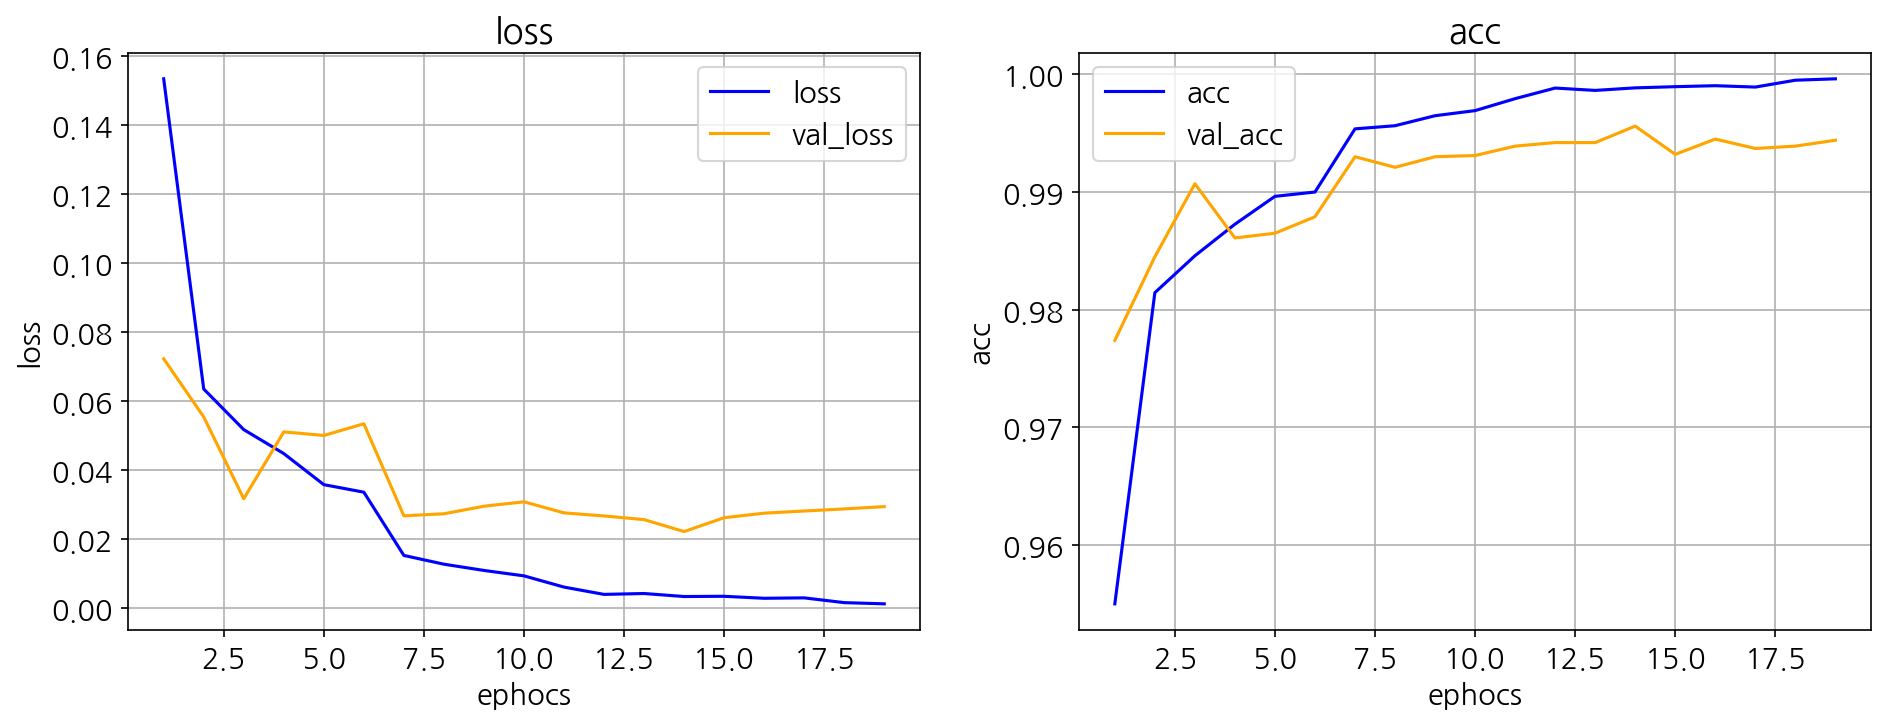

1875/1875 [==============================] - 7s 3ms/step - loss: 9.7759e-05 - acc: 1.0000
최종 훈련 손실률: 0.000098, 최종 훈련 정확도: 0.999983
313/313 [==============================] - 1s 3ms/step - loss: 0.0294 - acc: 0.9944
최종 검증 손실률: 0.029414, 최종 검증 정확도: 0.994400


In [ ]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train_reshape, y_train_one_hot)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test_reshape, y_test_one_hot)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #8. 학습 결과 적용

### 훈련 데이터에 대한 예측 결과 산정

In [ ]:
result = model.predict(x_train_reshape)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

1875/1875 [==============================] - 4s 2ms/step
60000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([1.0488508e-20, 7.2782266e-18, 1.1444644e-21, 1.2802654e-05,
       5.0820522e-24, 9.9998724e-01, 5.2796378e-18, 1.0051718e-18,
       1.7895979e-13, 1.5568543e-12], dtype=float32)

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [ ]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([5, 0, 4, ..., 5, 6, 8])

### 데이터 비교

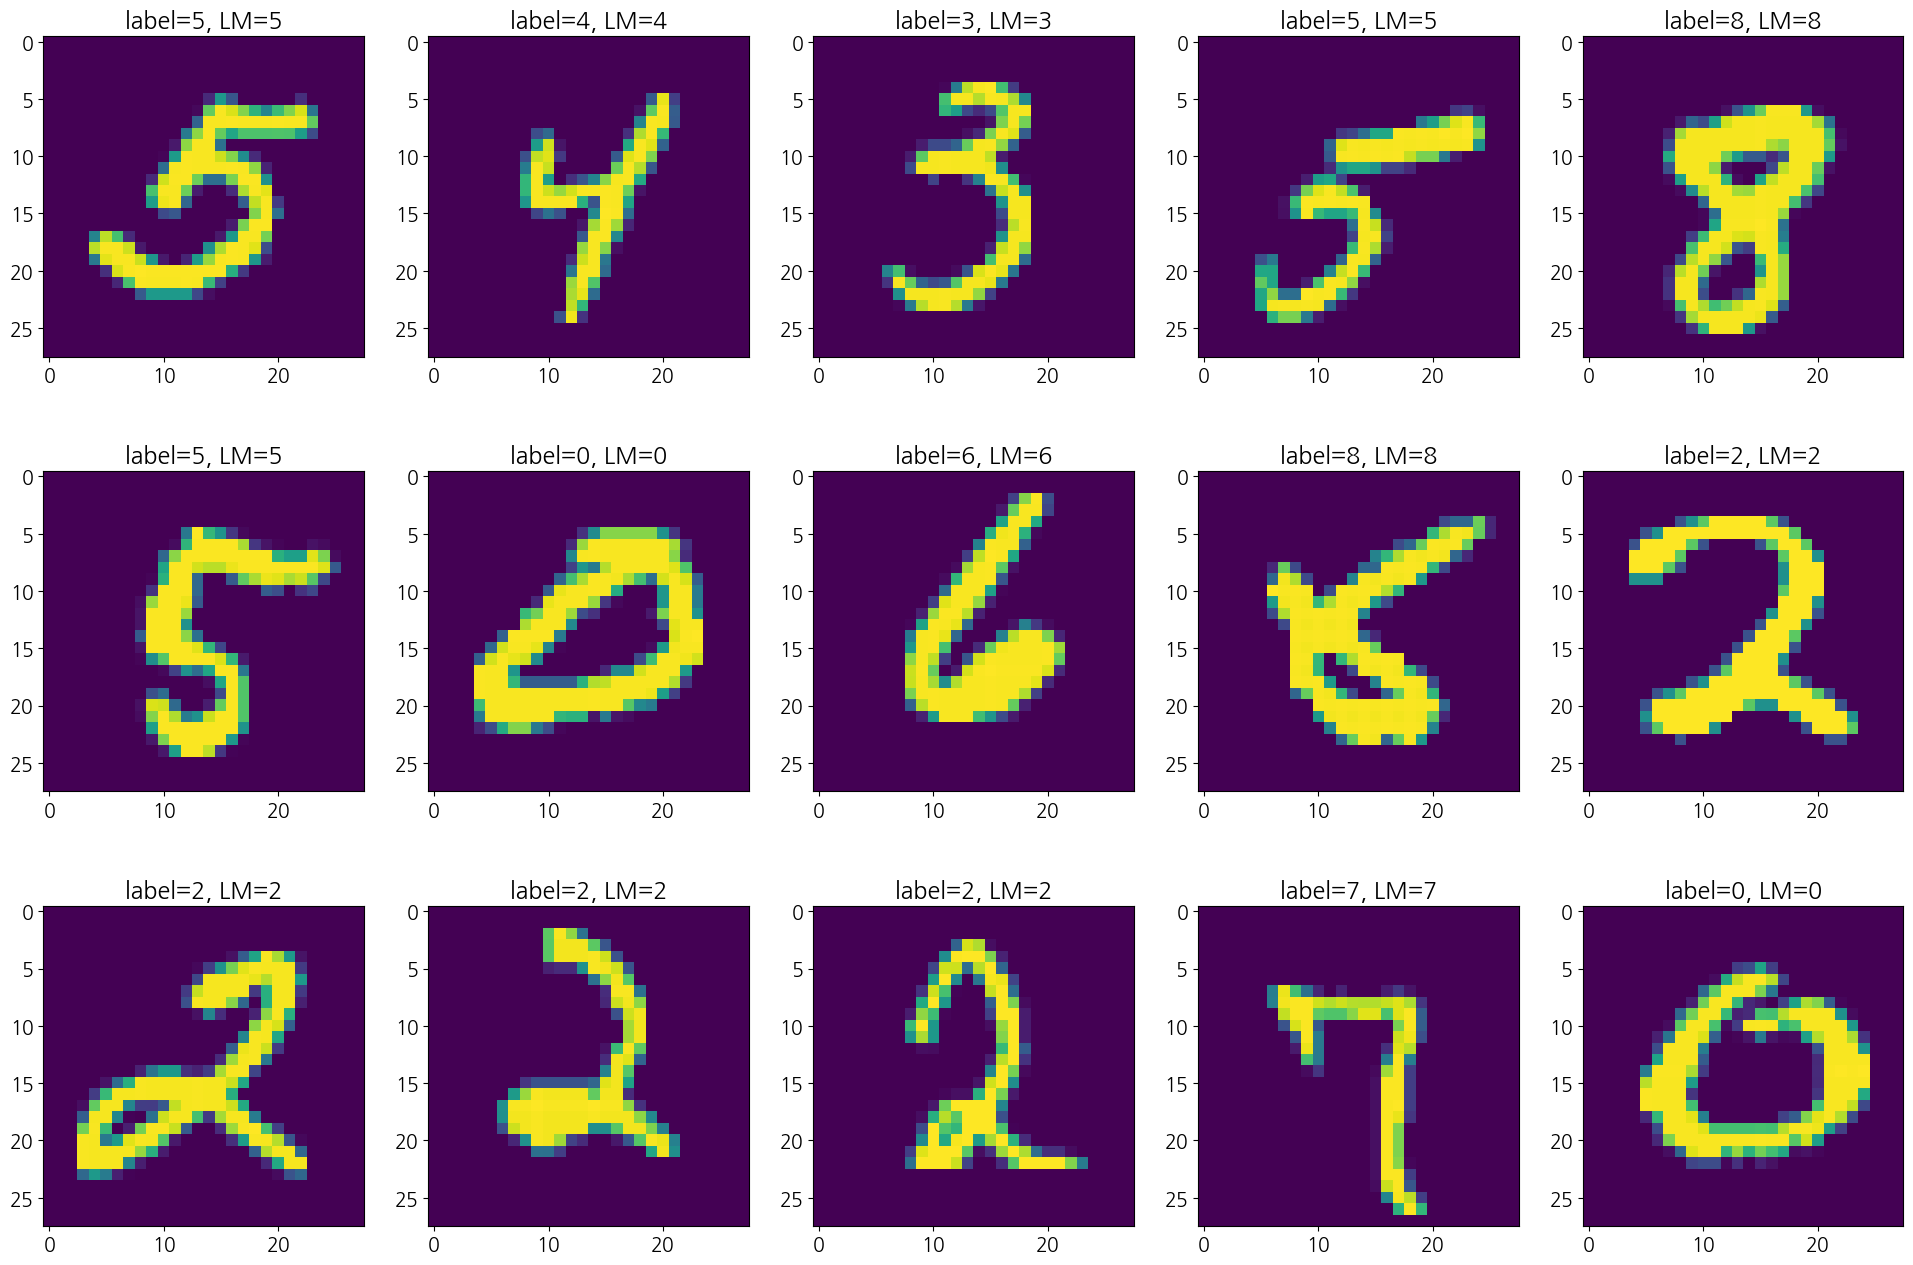

In [ ]:
row = 3
col = 5
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

size = row*col
length = len(y_train)

for i in range(0, size):
    k = np.random.randint(length)
    train = x_train[k]
    label = y_train[k]
    ax[i//col][i%col].imshow(train)
    ax[i//col][i%col].set_title("label=%d, LM=%d" % (label, arg_result[k]))

plt.show()
plt.close()

### 혼동행렬

정확도(accuracy) 외에도 모델의 성능을 다양한 측면에서 평가

In [ ]:
cm = confusion_matrix(y_train, arg_result)
cmdf2 = DataFrame(cm, columns=list(map(lambda x: "실제값(%d)" % x, range(10))), index=list(map(lambda x: "예측값(%d)" % x, range(10))))
cmdf2

,실제값(0),실제값(1),실제값(2),실제값(3),실제값(4),실제값(5),실제값(6),실제값(7),실제값(8),실제값(9)
예측값(0),5923,0,0,0,0,0,0,0,0,0
예측값(1),0,6742,0,0,0,0,0,0,0,0
예측값(2),0,0,5958,0,0,0,0,0,0,0
예측값(3),0,0,0,6130,0,0,0,0,0,1
예측값(4),0,0,0,0,5842,0,0,0,0,0
예측값(5),0,0,0,0,0,5421,0,0,0,0
예측값(6),0,0,0,0,0,0,5918,0,0,0
예측값(7),0,0,0,0,0,0,0,6265,0,0
예측값(8),0,0,0,0,0,0,0,0,5851,0
예측값(9),0,0,0,0,0,0,0,0,0,5949


### 혼동행렬 히트맵

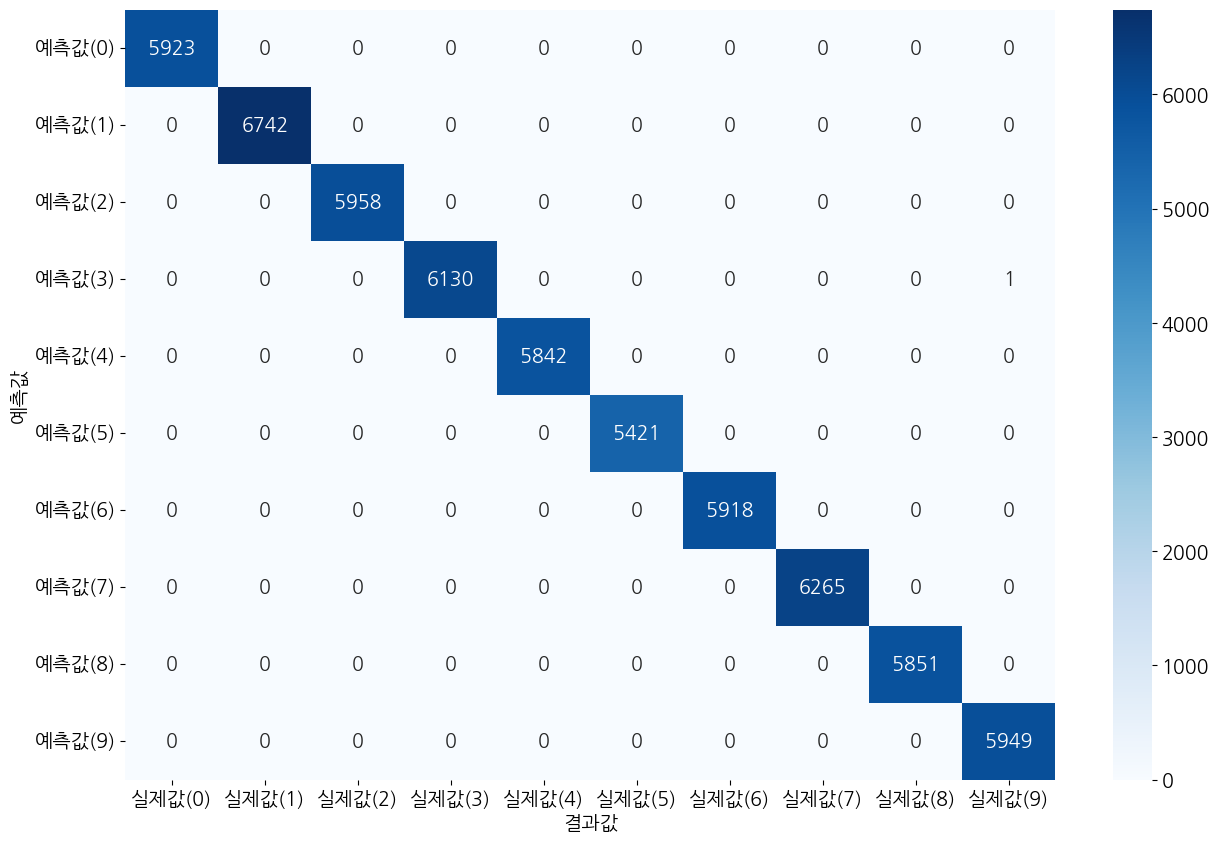

In [ ]:
plt.figure(figsize=(15, 10))
sb.heatmap(cmdf2, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('결과값')
plt.ylabel('예측값')
plt.show()
plt.close()